# PubMed 200k RCT: Dataset for Sequential Sentence Classification

**Main model architecture:** https://arxiv.org/pdf/1612.05251.pdf

In [77]:
# Importing modules
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import random

# Custom
from helper_function.preprocessing import get_raw_data
from helper_function.niffo_helper import calculate_result
from helper_function import niffo_plotter

## Getting Data Ready
**Link:** https://github.com/Franck-Dernoncourt/pubmed-rct

`!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git`

In [2]:
# Using 20k dataset for the initial model
data_dir = "Data/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

### Preprocessing Data

In [3]:
train_data = get_raw_data(data_dir + "train.txt")
val_data = get_raw_data(data_dir + "dev.txt")
test_data = get_raw_data(data_dir + "test.txt")

In [4]:
len(train_data), len(val_data), len(test_data)

(180040, 30212, 30135)

In [5]:
train_data[0]

{'target': 'OBJECTIVE',
 'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'line_number': 0,
 'total_lines': 11}

### Making pandas DataFrame

In [6]:
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)
val_df = pd.DataFrame(val_data)

In [7]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [8]:
test_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8
1,RESULTS,a post hoc analysis was conducted with the use...,1,8
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8
3,RESULTS,survival analyses were used to assess the asso...,3,8
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8


In [9]:
val_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,ige sensitization to aspergillus fumigatus and...,0,9
1,BACKGROUND,it is not clear whether these patients would b...,1,9
2,OBJECTIVE,we sought to determine whether a @-month cours...,2,9
3,METHODS,asthmatic patients who were ige sensitized to ...,3,9
4,METHODS,primary outcomes were improvement in quality o...,4,9


### Getting the sentences

In [10]:
train_sen = train_df["text"].tolist()
val_sen = val_df["text"].tolist()
test_sen = test_df["text"].tolist()

In [11]:
train_sen[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

### Making numerical labels

In [12]:
ohe = OneHotEncoder(sparse=False)
train_labels = ohe.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
test_labels = ohe.fit_transform(test_df["target"].to_numpy().reshape(-1, 1))
val_labels = ohe.fit_transform(val_df["target"].to_numpy().reshape(-1, 1))

In [13]:
tf.constant(train_labels)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

### Encoding labels

In [14]:
label_encoder = LabelEncoder()
etrain_labels = label_encoder.fit_transform(train_df["target"].to_numpy())
etest_labels = label_encoder.fit_transform(test_df["target"].to_numpy())
eval_labels = label_encoder.fit_transform(val_df["target"].to_numpy())

In [15]:
etrain_labels, etest_labels, eval_labels

(array([3, 2, 2, ..., 4, 1, 1]),
 array([0, 4, 4, ..., 4, 4, 1]),
 array([0, 0, 3, ..., 4, 1, 1]))

In [16]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

## Model 0: BaseLine model

(TF-IDF Multinomial Naive Bayes Classifier).

**Score:**

`accuracy': 71.66%`

`precision': 0.7124322482375202`

`recall': 0.716674962667994,`

`f1-score': 0.6925101703856846`

In [17]:
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB()),
])
model_0.fit(train_sen, etrain_labels)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [67]:
model_0.score(val_sen, eval_labels)

0.7218323844829869

In [68]:
model_0_preds = model_0.predict(test_sen)

In [69]:
model_0_res = calculate_result(y_true=etest_labels, y_predict=model_0_preds)
model_0_res

{'accuracy': 71.6674962667994,
 'precision': 0.7124322482375202,
 'recall': 0.716674962667994,
 'f1-score': 0.6925101703856846}

## Model 1: Convolutional 1-D model
(Conv1D with token embeddings)

**Score:**

`accuracy': 78.52%`

`precision': 0.7817069791201003`

`recall': 0.7852663016426082`
 
`f1-score': 0.782223028043873`

In [21]:
sen_len = [len(sen.split()) for sen in train_sen]
np.mean(sen_len)

26.338269273494777

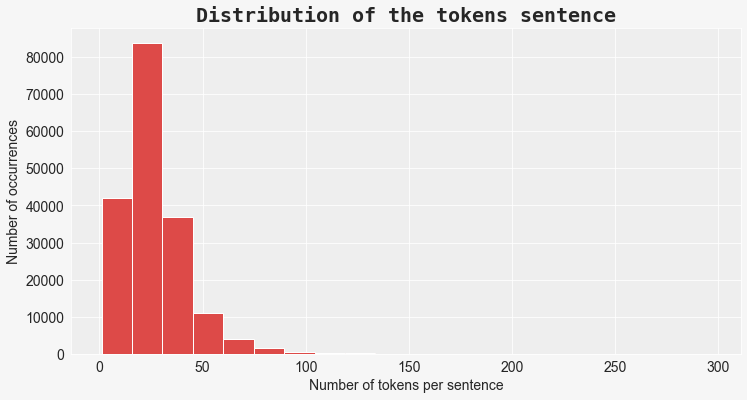

In [22]:
niffo_plotter.plot_histogram(data=sen_len,
                             xlabel="Number of tokens per sentence",
                             ylabel="Number of occurrences",
                             title="Distribution of the tokens sentence",
                             bins=20)

In [23]:
# The graph represents taking 95% of the data is safe for the sequences length output
out_seq_len = int(np.percentile(sen_len, 95))
out_seq_len

55

In [24]:
max(sen_len) # Outlier

296

### Creating text vector and embedding layer

In [25]:
# Preparing text vector
text_vector = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=68000,
                                                                          output_sequence_length=out_seq_len)
text_vector.adapt(train_sen)

In [26]:
embed = tf.keras.layers.Embedding(input_dim=68000,
                                 output_dim=128,
                                 input_length=out_seq_len)

In [27]:
text_vector(["checking if it is working"])

<tf.Tensor: shape=(1, 55), dtype=int64, numpy=
array([[61684,   324,   185,    20,  1615,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int64)>

### Creating datasets for loading the data efficiently

In [28]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sen, train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sen, val_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_sen, test_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [29]:
train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

### Preparing convolutional model architecture

In [113]:
# Input layer
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name="input_layer")

# Text Vectorization
x = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=68000,
                                                                output_sequence_length=55)
x.adapt(train_sen)

# Apply text vectorization on inputs
x = x(inputs)

# Adding Embedding layer
x = tf.keras.layers.Embedding(input_dim=68000,
                             output_dim=128,
                             input_length=55)(x)
# Adding Conv1D layer
x = tf.keras.layers.Conv1D(filters=64,
                           kernel_size=5,
                           activation="relu",
                           name="conv1D_layer",
                           padding="same")(x)
# Applying pooling layer
x = tf.keras.layers.GlobalAveragePooling1D()(x)

# Adding output layer
outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="output_layer")(x)

# Combining into model_1
model_1 = tf.keras.Model(inputs, outputs)

# Compiling the model
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [114]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None,)]                 0         
                                                                 
 text_vectorization_2 (TextV  (None, 55)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 55, 128)           8704000   
                                                                 
 conv1D_layer (Conv1D)       (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 output_layer (Dense)        (None, 5)                 325 

In [32]:
# Fitting the data into the model
his_1 = model_1.fit(train_dataset,
            epochs=5,
            validation_data=valid_dataset)

Epoch 1/5
5627/5627 [==============================] - 69s 12ms/step - loss: 0.6134 - accuracy: 0.7772 - val_loss: 0.5337 - val_accuracy: 0.8103
Epoch 2/5
5627/5627 [==============================] - 63s 11ms/step - loss: 0.4509 - accuracy: 0.8418 - val_loss: 0.5331 - val_accuracy: 0.8107
Epoch 3/5
5627/5627 [==============================] - 64s 11ms/step - loss: 0.3705 - accuracy: 0.8734 - val_loss: 0.5689 - val_accuracy: 0.8060
Epoch 4/5
5627/5627 [==============================] - 63s 11ms/step - loss: 0.3061 - accuracy: 0.8986 - val_loss: 0.6316 - val_accuracy: 0.7998
Epoch 5/5
5627/5627 [==============================] - 64s 11ms/step - loss: 0.2519 - accuracy: 0.9189 - val_loss: 0.7133 - val_accuracy: 0.7927


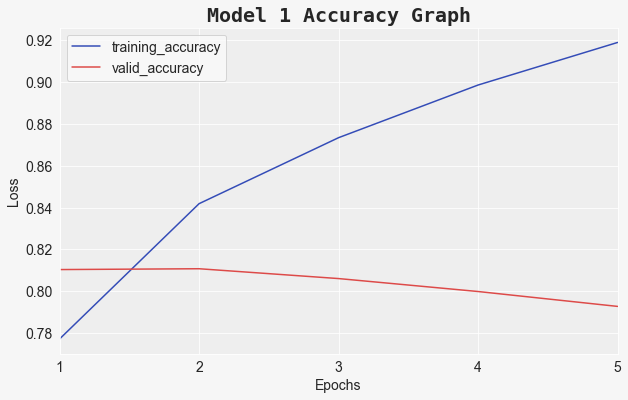

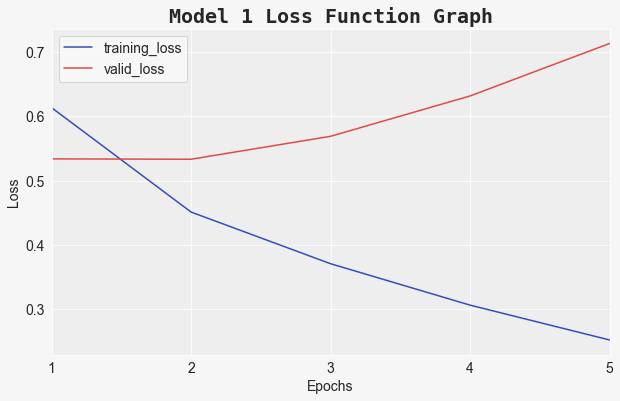

In [33]:
niffo_plotter.plot_model_history_accuracy(his_1, model_name="Model 1")
niffo_plotter.plot_model_history_loss(his_1, model_name="Model 1")

In [63]:
# Predicting test data
model_1_preds = model_1.predict(test_dataset)
model_1_preds

array([[4.7201574e-01, 4.4827137e-02, 7.2766118e-02, 2.8386712e-01,
        1.2652382e-01],
       [5.1982719e-03, 1.7382787e-03, 3.3681342e-01, 5.7915307e-04,
        6.5567094e-01],
       [5.5592158e-05, 3.4187187e-04, 9.5717043e-01, 2.3903153e-04,
        4.2193085e-02],
       ...,
       [1.4535477e-05, 5.7711485e-03, 1.1701442e-04, 4.2504785e-06,
        9.9409300e-01],
       [9.3992049e-04, 8.7802019e-03, 1.5146021e-03, 2.5831844e-04,
        9.8850691e-01],
       [1.4891597e-03, 5.4237027e-02, 3.7600681e-02, 6.9373018e-06,
        9.0666622e-01]], dtype=float32)

In [64]:
model_1_preds = np.argmax(model_1_preds, axis=1)
model_1_preds

array([0, 4, 2, ..., 4, 4, 4], dtype=int64)

In [65]:
calculate_result(y_true=etest_labels, y_predict=model_1_preds)

{'accuracy': 78.52663016426082,
 'precision': 0.7817069791201003,
 'recall': 0.7852663016426082,
 'f1-score': 0.782223028043873}

## Model 2: Transfer learning Feature Extraction model

Pretrained base model link - https://tfhub.dev/google/universal-sentence-encoder/4

**Score:**

`accuracy': 76.76455948232952%`

`precision': 0.7651474813371973`

`recall': 0.7676455948232952`

`f1-score': 0.763595417021131`

In [74]:
pretrained_dir = "Pretrained/universal-sentence-encoder_4" # or Pretrained base model link

In [75]:
# Loading embedding layer
embedding_layer = hub.KerasLayer(pretrained_dir, trainable=False, name="universal_sentence_encoder")

In [94]:
# Testing embedding layer
sen = random.choice(train_sen)
print(f"Choosen sentence:\n{sen}")
embedded_sen = embedding_layer([sen])
print(f"\nApplied embedding layer:\n{embedded_sen[0][:24]}\n\nShape: {embedded_sen.shape}")

Choosen sentence:
the bp was reduced and hr was slowed down during the surgery in the group b , which was significantly different from those before the surgery as well as those in the group a ( all p < @ ) .

Applied embedding layer:
[-0.07324564 -0.04118772  0.0588896  -0.05857951  0.05178926  0.01704634
  0.03539573  0.00746025 -0.03802553  0.01841341  0.07865864 -0.01988664
  0.05973684  0.04813515  0.04108053  0.04236158 -0.07172233  0.00149216
  0.01015279  0.0586522  -0.06436732  0.01632371 -0.03290316  0.02759215]

Shape: (1, 512)


In [112]:
# Creating input layer
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name="input_layer")

# Passing inputs to the embedding layer
x = embedding_layer(inputs)

# adding layers
x = tf.keras.layers.Dense(128, activation="relu")(x)

# Creating output layer
outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="output_layer")(x)

# Combining inputs and outputs
model_2 = tf.keras.Model(inputs, outputs, name="output_layer")


# Compiling the model
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [115]:
model_2.summary()

Model: "output_layer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 output_layer (Dense)        (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [116]:
# Fitting the train and validation data
his_2 = model_2.fit(train_dataset,
                    epochs=5,
                    validation_data=valid_dataset)

Epoch 1/5
5627/5627 [==============================] - 95s 16ms/step - loss: 0.7308 - accuracy: 0.7203 - val_loss: 0.6580 - val_accuracy: 0.7498
Epoch 2/5
5627/5627 [==============================] - 92s 16ms/step - loss: 0.6370 - accuracy: 0.7580 - val_loss: 0.6217 - val_accuracy: 0.7638
Epoch 3/5
5627/5627 [==============================] - 91s 16ms/step - loss: 0.6023 - accuracy: 0.7728 - val_loss: 0.6061 - val_accuracy: 0.7706
Epoch 4/5
5627/5627 [==============================] - 91s 16ms/step - loss: 0.5798 - accuracy: 0.7810 - val_loss: 0.5991 - val_accuracy: 0.7740
Epoch 5/5
5627/5627 [==============================] - 92s 16ms/step - loss: 0.5629 - accuracy: 0.7878 - val_loss: 0.5967 - val_accuracy: 0.7753


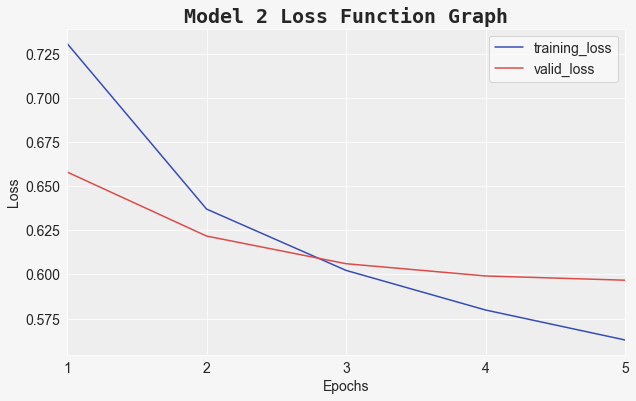

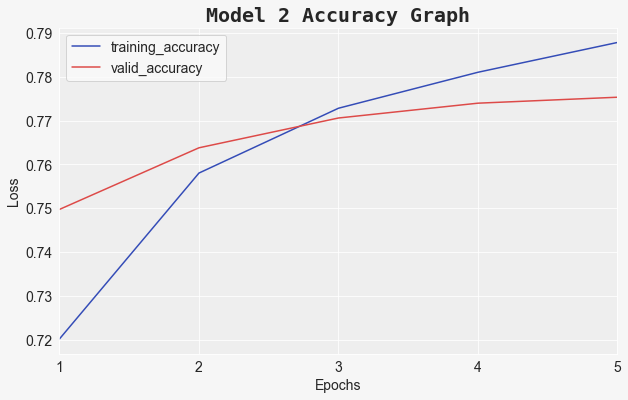

In [117]:
niffo_plotter.plot_model_history_loss(his_2, model_name="Model 2")
niffo_plotter.plot_model_history_accuracy(his_2, model_name="Model 2")

In [118]:
model_2_preds = tf.argmax(model_2.predict(test_dataset), axis=1)
calculate_result(y_true=etest_labels, y_predict=model_2_preds)

{'accuracy': 76.76455948232952,
 'precision': 0.7651474813371973,
 'recall': 0.7676455948232952,
 'f1-score': 0.763595417021131}

## Model 3: Convolutional 1-D with Character embeddings